# 03장 고객의 전체 모습을 파악하는 테크닉 10

## 021 데이터를 읽어들이고 확인하자

In [1]:
import pandas as pd
uselog = pd.read_csv('pyda100-master/3장/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [2]:
customer = pd.read_csv('pyda100-master/3장/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [3]:
class_master = pd.read_csv('pyda100-master/3장/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [4]:
campaign_master = pd.read_csv('pyda100-master/3장/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


## 022 고객 데이터를 가공하자

In [5]:
customer_join = pd.merge(customer, class_master, on="class", how="left")
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [6]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

## 023 고객 데이터를 집계하자

In [7]:
customer_join.groupby("class_name").count()["customer_id"]

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [8]:
customer_join.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

In [9]:
customer_join.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [10]:
customer_join.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [11]:
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


## 최신 고객 데이터를 집계하자

In [12]:
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
customer_newer.groupby("campaign_name").count()["customer_id"]


campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [14]:
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

## 025 이용 이력 데이터를 집계하자*

In [15]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id" : "count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [16]:
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min"])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


## 026 이용 이력 데이터로부터 정기 이용 플래그를 작성하자**

In [17]:
uselog["weekday"] = uselog["usedate"].dt.weekday
uselog_weekday = uselog.groupby(["customer_id", "연월", "weekday"], as_index=False).count()[["customer_id", "연월", "weekday", "log_id"]]
uselog_weekday.rename(columns={"log_id" : "count"}, inplace=True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [18]:
uselog_weekday = uselog_weekday.groupby("customer_id", as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


## 027 고객 데이터와 이용 이력 데이터를 결합하자

In [19]:
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [20]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

## 028 회원 기간을 계산하자

In [21]:
from dateutil.relativedelta import relativedelta
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months

customer_join.head()

/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


## 029 고객 행동의 각종 통계량을 파악하자

In [22]:
customer_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [23]:
customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

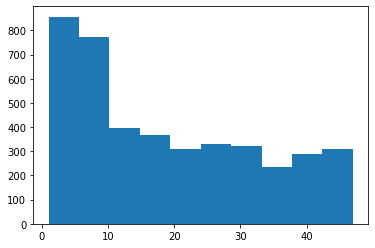

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

## 030 탈퇴 회원과 지속 회원의 차이를 파악하자

In [25]:
customer_end = customer_join.loc[customer_join["is_deleted"] == 1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [26]:
customer_stay = customer_join.loc[customer_join["is_deleted"] == 0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


In [27]:
customer_join.to_csv("customer_join.csv", index=False)

# 04장 고객의 행동을 예측하는 테크닉 10

## 031 데이터를 읽어들이고 확인하자

In [28]:
import pandas as pd
uselog = pd.read_csv('pyda100-master/3장/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [29]:
customer = pd.read_csv('pyda100-master/3장/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## 032 클러스터링으로 회원을 그룹화하자

In [30]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


<ipython-input-31-603608940e90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


## 033 클러스터링 결과를 분석하자

In [32]:
customer_clustering.columns = ["월평균값", "월중앙값", "월최댓값", "월최솟값", "회원기간", "cluster"]
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [33]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


## 034 클러스터링 결과를 가시화하자

In [34]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

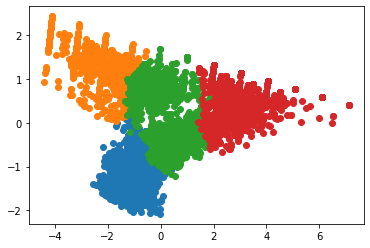

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [36]:
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,3
1,-0.707922,-1.799857,3
2,-1.061499,-1.659826,3
3,-1.160764,-1.810139,3
4,-2.017132,-1.670101,3


<AxesSubplot:xlabel='0', ylabel='1'>

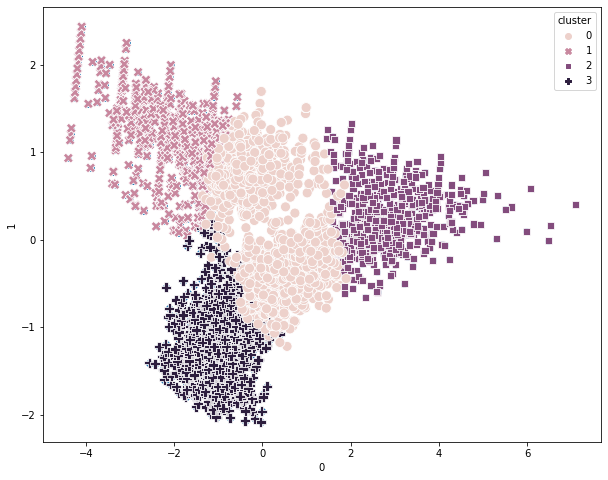

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_df[0], pca_df[1])
import seaborn as sns
sns.scatterplot(x=0, y=1, hue="cluster", style="cluster", s=100, data=pca_df)

## 035 클러스터링 결과를 바탕으로 탈퇴 회원의 경향을 파악하자

In [38]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [39]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


## 036 다음달의 이용 횟수 예측을 위해 데이터를 준비하자

In [40]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [41]:
year_months = list(uselog_months["연월"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [42]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


## 037 특징이 되는 변수를 추가하자

In [43]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [44]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years * 12 + delta.months
predict_data.head()

<ipython-input-44-6d6472fd0821>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years * 12 + delta.months


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## 038 다음달 이용 횟수를 예측하는 모델을 구축하자

In [45]:
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [46]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6072492714440002
0.6083365973313136


## 039 모델에 기여하는 변수를 확인하자

In [47]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.327123
1,count_1,0.180765
2,count_2,0.165054
3,count_3,0.166874
4,count_4,0.112608
5,count_5,0.072708
6,period,0.080391


## 040 다음달의 이용 횟수를 예측하자

In [48]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]
model.predict(x_pred)

array([3.89253012, 2.01506134])

In [49]:
uselog_months.to_csv("use_log_months.csv", index=False)

# 05장 회원 탈퇴를 예측하는 테크닉

## 041 데이터를 읽어 들이고 이용 데이터를 수정하자

In [71]:
import pandas as pd
customer = pd.read_csv('pyda100-master/3장/customer_join.csv')
uselog_months = pd.read_csv('use_log_months.csv')

In [72]:
year_months = list(uselog_months["연월"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-1]]
    del tmp_before["연월"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()

/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super

,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


## 042 탈퇴 전월의 탈퇴 고객 데이터를 작성하자

In [73]:
from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"] == 1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)

exit_customer["exit_date"] = pd.to_datetime(exit_customer["exit_date"])
exit_customer["연월"] = exit_customer["exit_date"].dt.strftime("%Y%m")
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "연월"], how="left")
print(len(uselog))
exit_uselog.head()

<ipython-input-73-f3589365eb2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["exit_date"] = None
<ipython-input-73-f3589365eb2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
/Users/tedz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

33851


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [74]:
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,2_일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30


## 043 지속 회원의 데이터를 작성하자

In [75]:
conti_customer = customer.loc[customer["is_deleted"] == 0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"])
print(len(conti_uselog))

33851
27422


In [76]:
# 데이터를 섞고 중복 제거
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog.head()

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201903,OA071756,4,4.0,XXX,C01,M,2015-05-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.166667,4.0,6.0,2.0,1.0,2019-04-30,47.0
1,201810,HI813166,5,7.0,XXXX,C02,F,2017-04-01,NaN,CA1,...,1_주간,7500.0,2_일반,6.000000,6.0,8.0,4.0,1.0,2019-04-30,24.0
2,201901,IK853780,7,6.0,XXXXX,C03,M,2017-12-01,NaN,CA3,...,2_야간,6000.0,1_입회비무료,6.166667,6.0,9.0,2.0,1.0,2019-04-30,16.0
3,201812,PL400427,6,6.0,XXX,C01,F,2017-01-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.500000,5.0,10.0,2.0,1.0,2019-04-30,27.0
4,201901,PL012044,7,10.0,XXX,C03,M,2018-04-14,NaN,CA3,...,2_야간,6000.0,1_입회비무료,7.250000,7.5,10.0,3.0,1.0,2019-04-30,12.0


In [77]:
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201903,OA071756,4,4.0,XXX,C01,M,2015-05-01,NaN,CA1,...,10500.0,2_일반,4.166667,4.0,6.0,2.0,1.0,2019-04-30,47.0,NaT
1,201810,HI813166,5,7.0,XXXX,C02,F,2017-04-01,NaN,CA1,...,7500.0,2_일반,6.000000,6.0,8.0,4.0,1.0,2019-04-30,24.0,NaT
2,201901,IK853780,7,6.0,XXXXX,C03,M,2017-12-01,NaN,CA3,...,6000.0,1_입회비무료,6.166667,6.0,9.0,2.0,1.0,2019-04-30,16.0,NaT
3,201812,PL400427,6,6.0,XXX,C01,F,2017-01-01,NaN,CA1,...,10500.0,2_일반,5.500000,5.0,10.0,2.0,1.0,2019-04-30,27.0,NaT
4,201901,PL012044,7,10.0,XXX,C03,M,2018-04-14,NaN,CA3,...,6000.0,1_입회비무료,7.250000,7.5,10.0,3.0,1.0,2019-04-30,12.0,NaT


## 044 예측할 달의 재적 기간을 작성하자

In [78]:
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)
predict_data.head()

<ipython-input-78-d308320693f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = int(delta.years*12 + delta.months)


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201903,OA071756,4,4.0,XXX,C01,M,2015-05-01,NaN,CA1,...,4.166667,4.0,6.0,2.0,1.0,2019-04-30,47.0,NaT,46,2019-03-01
1,201810,HI813166,5,7.0,XXXX,C02,F,2017-04-01,NaN,CA1,...,6.000000,6.0,8.0,4.0,1.0,2019-04-30,24.0,NaT,18,2018-10-01
2,201901,IK853780,7,6.0,XXXXX,C03,M,2017-12-01,NaN,CA3,...,6.166667,6.0,9.0,2.0,1.0,2019-04-30,16.0,NaT,13,2019-01-01
3,201812,PL400427,6,6.0,XXX,C01,F,2017-01-01,NaN,CA1,...,5.500000,5.0,10.0,2.0,1.0,2019-04-30,27.0,NaT,23,2018-12-01
4,201901,PL012044,7,10.0,XXX,C03,M,2018-04-14,NaN,CA3,...,7.250000,7.5,10.0,3.0,1.0,2019-04-30,12.0,NaT,8,2019-01-01


## 045 결측치를 제거하자

In [79]:
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1               253
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [80]:
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2641
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2641
period                  0
now_date                0
dtype: int64

## 046 문자열 변수를 처리할 수 있게 가공하자

In [82]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,2_일반,0_종일,M,4.0,1.0,46,0.0
1,2_일반,1_주간,F,7.0,1.0,18,0.0
2,1_입회비무료,2_야간,M,6.0,1.0,13,0.0
3,2_일반,0_종일,F,6.0,1.0,23,0.0
4,1_입회비무료,2_야간,M,10.0,1.0,8,0.0


In [83]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,campaign_name_2_일반,class_name_0_종일,class_name_1_주간,class_name_2_야간,gender_F,gender_M
0,4.0,1.0,46,0.0,0,0,1,1,0,0,0,1
1,7.0,1.0,18,0.0,0,0,1,0,1,0,1,0
2,6.0,1.0,13,0.0,0,1,0,0,0,1,0,1
3,6.0,1.0,23,0.0,0,0,1,1,0,0,1,0
4,10.0,1.0,8,0.0,0,1,0,0,0,1,0,1


In [84]:
del predict_data["campaign_name_2_일반"]
del predict_data["class_name_2_야간"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
0,4.0,1.0,46,0.0,0,0,1,0,0
1,7.0,1.0,18,0.0,0,0,0,1,1
2,6.0,1.0,13,0.0,0,1,0,0,0
3,6.0,1.0,23,0.0,0,0,1,0,1
4,10.0,1.0,8,0.0,0,1,0,0,0


## 047 의사결정 트리를 사용해서 탈퇴 예측 모델을 구축하자

In [85]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = predict_data.loc[predict_data["is_deleted"] == 1]
conti = predict_data.loc[predict_data["is_deleted"] == 0].sample(len(exit))

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1.

In [87]:
results_test = pd.DataFrame({"y_test":y_test, "y_pred":y_test_pred})
results_test.head()

,y_test,y_pred
1154,0.0,0.0
1459,0.0,0.0
161,1.0,1.0
1814,0.0,0.0
2038,0.0,0.0


## 048 예측 모델을 평가하고 모델을 튜닝해 보자

In [89]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count= len(results_test)
score_test = correct / data_count
print(score_test)

0.9049429657794676


In [90]:
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9049429657794676
0.9790874524714829


In [91]:
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8878326996197718
0.9321926489226869


## 049 모델에 기여하는 변수를 확인하자

In [92]:
importance = pd.DataFrame({"feature_names":X.columns, "coefficient":model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.355275
1,routine_flg,0.133438
2,period,0.510984
3,campaign_name_0_입회비반액할인,0.000000
4,campaign_name_1_입회비무료,0.000000
5,class_name_0_종일,0.000303
6,class_name_1_주간,0.000000
7,gender_F,0.000000


## 050 회원 탈퇴를 예측하자

In [93]:
count_1 = 3
routine_flg = 1
period = 10
campaign_name = "입회비무로"
class_name = "종일"
gender = "M"